# Inverse problem for the Poisson equation with unknown forcing field with training points resampling

## Problem setup

We will solve
$$
\nabla^2 u = q(x), \qquad x \in [-1, 1]
$$
with the Dirichlet boundary conditions
$$
u(-1) = 0, \qquad u(1) = 0
$$

The reference solution is $u(x) = \sin(\pi x), \qquad q(x) = -\pi^2 \sin(\pi x)$

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
os.environ['DDE_BACKEND'] = 'pytorch'

In [2]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.
/userhome/jeon_mg/miniforge3/envs/pinn_torch/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392020201/work/torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


In [3]:
def gen_traindata(num):
    xvals = np.linspace(-1, 1, num).reshape(-1, 1)
    uvals = np.sin(np.pi * xvals)
    return xvals, uvals

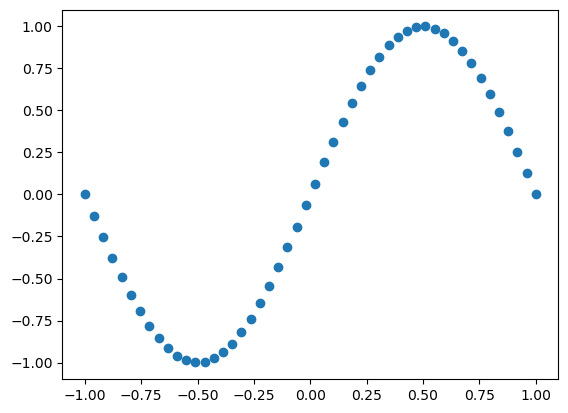

In [4]:
plt.scatter(*gen_traindata(50))

In [5]:
geom = dde.geometry.Interval(-1, 1)

In [6]:
def pde(x, Y):
    u = Y[:, 0:1]
    q = Y[:, 1:2]

    du_xx = dde.grad.hessian(Y, x, component=0, i=0, j=0)
    return du_xx - q

In [7]:
def boundary(x, on_boundary):
    return on_boundary

In [8]:
def func_D(x):
    return 0

In [9]:
bc_u = dde.icbc.DirichletBC(geom, func_D, boundary, component=0)

In [10]:
ob_x, ob_u = gen_traindata(10000)

In [11]:
observe_u = dde.icbc.PointSetBC(ob_x, ob_u, component=0, batch_size=100)

In [12]:
pde_resampler = dde.callbacks.PDEPointResampler(bc_points=True)

In [13]:
data = dde.data.PDE(geom,
                    pde,
                    [bc_u, observe_u],
                    num_domain=200,
                    num_boundary=2,
                    num_test=1000)

We use two networks, one to train for `u(x)` and the other to train for `q(x)`. 

Here, we use two fully connected neural networks of depth 4 (i.e., 3 hidden layers) and width 20.

In [14]:
layer_size = [1, [20, 20], [20, 20], [20, 20], 2]
activation = "tanh"
initializer = "Glorot uniform"

In [15]:
net = dde.nn.PFNN(layer_size, activation, initializer)

In [16]:
model = dde.Model(data, net)

In [17]:
model.compile("adam", lr=0.0001, loss_weights=[1, 100, 1000])

Compiling model...
'compile' took 0.279380 s



In [18]:
loss_history, train_state = model.train(iterations=20000, callbacks=[pde_resampler])

Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.32e-01, 4.08e+00, 6.06e+02]    [2.27e-01, 4.08e+00, 6.06e+02]    []  
1000      [3.20e+00, 2.55e+01, 8.83e+01]    [3.22e+00, 2.55e+01, 7.62e+02]    []  
2000      [3.99e+00, 1.02e+01, 1.88e+01]    [4.02e+00, 1.02e+01, 6.58e+02]    []  
3000      [6.88e-01, 4.08e+00, 9.66e+00]    [6.83e-01, 4.08e+00, 1.07e+03]    []  
4000      [6.31e-02, 2.06e+00, 5.59e+00]    [6.18e-02, 2.06e+00, 8.33e+02]    []  
5000      [8.38e-03, 6.92e-01, 3.19e+00]    [7.93e-03, 6.92e-01, 1.07e+03]    []  
6000      [1.23e-03, 2.54e-01, 1.22e+00]    [1.15e-03, 2.54e-01, 1.13e+03]    []  
7000      [3.80e-04, 7.08e-02, 4.27e-01]    [3.54e-04, 7.08e-02, 1.04e+03]    []  
8000      [2.29e-04, 4.93e-03, 8.58e-02]    [2.15e-04, 4.93e-03, 8.66e+02]    []  
9000      [1.87e-04, 1.46e-03, 1.22e-02]    [1.79e-04, 1.46e-03, 7.96e+02]    []  
10000     [1.03e-04, 1.64e-03, 5.92e-03]    [9.90e-05, 1.64e-

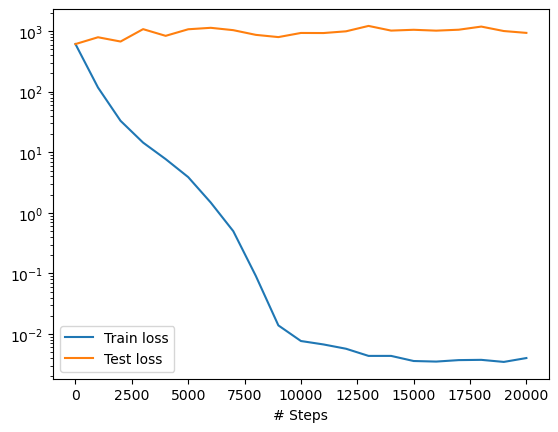

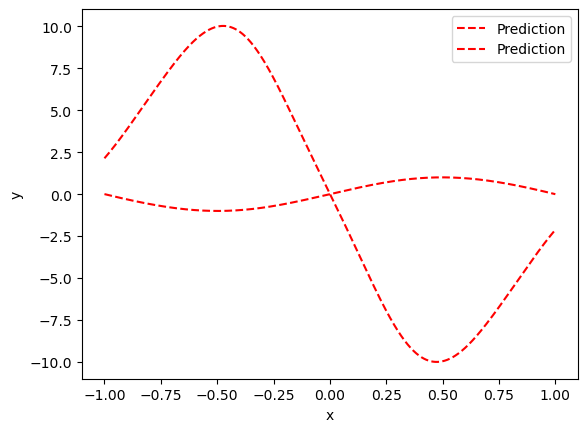

In [19]:
dde.saveplot(loss_history, train_state, issave=False, isplot=True)

In [20]:
x = geom.uniform_points(500)
Yhat = model.predict(x)
uhat, qhat = Yhat[:, 0:1], Yhat[:, 1:2] 

In [21]:
utrue = np.sin(np.pi*x)
qtrue = -np.pi**2 * np.sin(np.pi*x)

In [22]:
print(f"l2 relative error for u: {dde.metrics.l2_relative_error(utrue, uhat)}")

l2 relative error for u: 0.002498428337275982


In [23]:
print(f"l2 relative error for q: {dde.metrics.l2_relative_error(qtrue, qhat)}")

l2 relative error for q: 0.07597947120666504


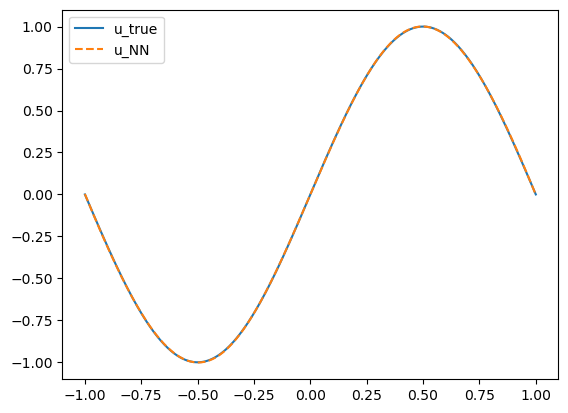

In [24]:
plt.figure()
plt.plot(x, utrue, '-', label='u_true')
plt.plot(x, uhat, '--', label='u_NN')
plt.legend()
plt.show()

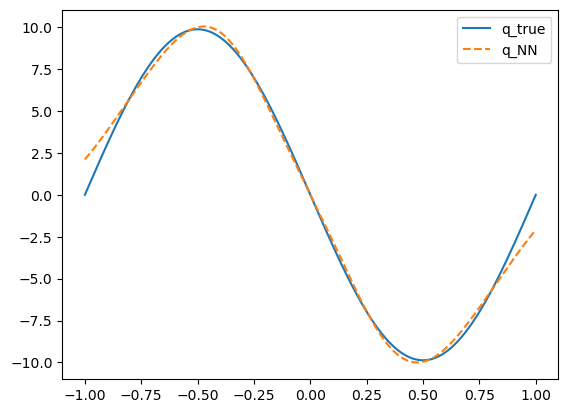

In [25]:
plt.figure()
plt.plot(x, qtrue, '-', label='q_true')
plt.plot(x, qhat, '--', label='q_NN')
plt.legend()
plt.show()